In [1]:
import warnings, os
warnings.filterwarnings("ignore")
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn import preprocessing
import numpy as np
import shutil
import tensorflow as tf
import tensorflow.keras as k
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, TensorBoard, LambdaCallback
from tensorflow.keras import optimizers
from tensorflow.keras import backend as K
from tensorflow.keras.models import load_model
from tensorflow.python.saved_model import builder as saved_model_builder
from tensorflow.python.saved_model.signature_def_utils import predict_signature_def
from tensorflow.python.saved_model import tag_constants
import pydicom
from tensorflow.keras import regularizers
from sklearn.metrics import mean_absolute_error
import seaborn as sns
import cv2

# Support Functions

In [3]:
def continious_to_categorical(data):
    median = data.median()
    low = data.min()
    high = data.max()
    lmedian = (low+median)/2
    rmedian = (high+median)/2
    temp = []
    for v in data:
        if v < (lmedian+median)/2:
            temp.append(1)
        elif v > (rmedian+median)/2:
            temp.append(2)
        else:
            temp.append(3)
    return pd.Series(temp)

def read_file(filename):
    data = pd.read_csv(filename,encoding = "ISO-8859-1")
    return data
def split_csv(data, s_ratio, case, seed_val=42):
    chunks = []
    np.random.seed(seed_val)
    seeds = np.random.randint(1,45,3)
    i = 0
    if case == 1:
        for cr in s_ratio[:-1]:
            data, d = train_test_split(data, test_size=cr, random_state = seeds[i])
            chunks.append(d)
            i += 1
        chunks.append(data)
        return chunks, seeds
    elif case == 2:
        for cr in s_ratio:
            data, d = train_test_split(data, test_size=cr, random_state = seeds[i])
            chunks.append(d)
            i += 1
        return chunks, seeds
    elif case == 3:
        for cr in s_ratio:
            _ , d = train_test_split(data, test_size=cr, random_state = seeds[i])
            chunks.append(d)
            i += 1
        return chunks, seeds


def normalize_ratio(ratio, n_samples):
    if len(ratio) != 3:
        print("error: Ratio has less/more than three numbers")
        exit(1)
    if sum(ratio) <= 100:
        #ratio.reverse()
        c_sizes = [(r/100)*n_samples for r in ratio]
        norm = []
        items_left = n_samples
        for cs in c_sizes:
            cr = cs / items_left
            norm.append(cr)
            items_left -= cs
        if sum(ratio) == 100:
            case = 1
        else:
            case = 2
        return norm, case
    elif sum(ratio) > 100:
        case = 3
        norm = [r/100 for r in ratio]
        return norm, case
    else:
        print("Ratio is not correct")
        exit(1)

def split_imgs(seed, files, case):
    chunks = []
    np.random.seed(seed)
    seeds = np.random.randint(1,45,3)
    i = 0
    if case == 1:
        for cr in s_ratio[:-1]:
            files, d = train_test_split(files, test_size=cr, random_state = seeds[i])
            chunks.append(d)
            i += 1
        chunks.append(files)
        return chunks
    elif case == 2:
        for cr in s_ratio:
            files, d = train_test_split(files, test_size=cr, random_state = seeds[i])
            chunks.append(d)
            i += 1
        return chunks
    elif case == 3:
        for cr in s_ratio:
            _ , d = train_test_split(files, test_size=cr, random_state = seeds[i])
            chunks.append(d)
            i += 1
        return chunks

def save_csv_chunks(chunks, filename, outputdir, filetype):
    fname = os.path.splitext(filename)[0]
    fname = fname.split('/')[-1]
    ext = os.path.splitext(filename)[1]
    if not os.path.exists(outputdir[0] + filetype):
        os.makedirs(outputdir[0] + filetype)
    chunks[0].to_csv(outputdir[0] + filetype + '/' + fname + '_' + 'train' + ext, index = 0)
    if not os.path.exists(outputdir[1] + filetype):
        os.makedirs(outputdir[1] + filetype)
    chunks[1].to_csv(outputdir[1] + filetype + '/'  + fname + '_' + 'val' + ext, index = 0)
    if not os.path.exists(outputdir[2] + filetype):
        os.makedirs(outputdir[2] + filetype)
    chunks[2].to_csv(outputdir[2] + filetype + '/'  + fname + '_' + 'test' + ext, index = 0)

def save_imgs(img_chunks, imgfolder, outputdir, filetype):
    if not os.path.exists(outputdir[0] + filetype):
        os.makedirs(outputdir[0] + filetype)
    for f in img_chunks[0]:
        shutil.copyfile(imgfolder + f, outputdir[0] + filetype + '/' + f)
        
    if not os.path.exists(outputdir[1] + filetype):
        os.makedirs(outputdir[1] + filetype)
    for f in img_chunks[1]:
        shutil.copyfile(imgfolder + f , outputdir[1] + filetype + '/' + f)
#         print(outputdir[1] + filetype + f)
        
    if not os.path.exists(outputdir[2] + filetype):
        os.makedirs(outputdir[2] + filetype)
    for f in img_chunks[2]:
        shutil.copyfile(imgfolder + f, outputdir[2] + filetype + '/' + f)
        
def build_cnn_block(img_input_shape, penalty):
    cnn_input = k.layers.Input(shape=img_input_shape, name='img_input')
    cnn_block = k.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_regularizer=regularizers.l2(penalty),
                activity_regularizer=regularizers.l1(penalty))(cnn_input)
    cnn_block = k.layers.MaxPooling2D(pool_size=(2, 2))(cnn_block)
    cnn_block = k.layers.Dropout(0.25)(cnn_block)
    cnn_block = k.layers.Flatten()(cnn_block)
    cnn_block = k.layers.Dense(32, activation='relu', kernel_regularizer=regularizers.l2(penalty),
                activity_regularizer=regularizers.l1(penalty))(cnn_block)
    return cnn_block, cnn_input

def build_dense_block(csv_input_shape, penalty):
    csv_input = k.layers.Input(shape=csv_input_shape, name='csv_input')
    dense_block = k.layers.Dense(32,activation='tanh',kernel_regularizer=regularizers.l2(penalty),
                activity_regularizer=regularizers.l1(penalty))(csv_input)
    dense_block = k.layers.Dropout(0.25)(dense_block)
    dense_block = k.layers.Flatten()(dense_block)
    dense_block = k.layers.Dense(32, activation='tanh', kernel_regularizer=regularizers.l2(penalty),
                activity_regularizer=regularizers.l1(penalty))(dense_block)
    return dense_block, csv_input

In [4]:
if not os.path.exists('../output/clinical'):
    os.makedirs('../output/clinical')
    
if os.getenv('DKUBE_JOB_CLASS',None) == 'notebook':
    modeldir = "../model/"
    if os.path.exists(modeldir):
        shutil.rmtree(modeldir)
    if not os.path.exists(modeldir):
        os.makedirs(modeldir)
else:
    modeldir = "/opt/dkube/output/"

# 1 - Preprocessing of clinical data

In [5]:
coi = ['vital_status', 'bcr_patient_barcode',
      'age_at_initial_pathologic_diagnosis','bcr_patient_canonical_status',
      'days_to_birth','ethnicity', 'gender',
      'histological_type', 'history_of_neoadjuvant_treatment',
      'initial_pathologic_diagnosis_method', 'karnofsky_performance_score',
      'performance_status_scale_timing', 'person_neoplasm_cancer_status',
      'postoperative_rx_tx', 'prior_glioma','tissue_source_site','days_to_death']

string_features = ['vital_status', 'ethnicity', 'bcr_patient_canonical_status',
                  'gender', 'histological_type', 'history_of_neoadjuvant_treatment',
                  'initial_pathologic_diagnosis_method', 'performance_status_scale_timing',
                  'person_neoplasm_cancer_status', 'postoperative_rx_tx', 'prior_glioma',
                  'tissue_source_site']
range_f = ['age_at_initial_pathologic_diagnosis']
ctn_r = ['age_at_initial_pathologic_diagnosis', 'days_to_birth', ]
ctn_min_max = ['karnofsky_performance_score']
filename = "/opt/dkube/input/clinical/All_CDEs.csv"
outfile = '../output/clinical/cli_data_processed.csv'
data = read_file(filename)
data = data[coi]
data = data.fillna(0)

## 1.1 - Raw data visualization

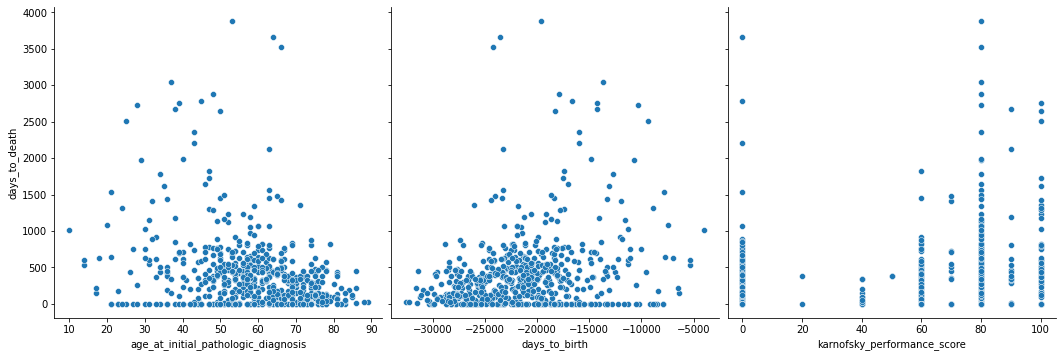

In [6]:
x_vars = ['age_at_initial_pathologic_diagnosis', 'days_to_birth', 'karnofsky_performance_score']
sns.pairplot(data, x_vars=x_vars, y_vars='days_to_death', height=5, aspect=1)

## 1.2 - Data Preprocessing and visualization

In [7]:
data[string_features] = data[string_features].apply(lambda x: pd.factorize(x)[0] + 1)
float_array = data['karnofsky_performance_score'].values.astype(float)
float_array = float_array.reshape(float_array.shape[0],1)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
data['karnofsky_performance_score'] = pd.DataFrame(scaled_array)
data['age_at_initial_pathologic_diagnosis'] = continious_to_categorical(data['age_at_initial_pathologic_diagnosis'])
data['days_to_birth'] = continious_to_categorical(data['days_to_birth'])

float_array = data['days_to_death'].values.astype(float)
float_array = float_array.reshape(float_array.shape[0],1)
min_max_scaler = preprocessing.MinMaxScaler()
scaled_array = min_max_scaler.fit_transform(float_array)
data['days_to_death'] = pd.DataFrame(scaled_array)
data.to_csv(outfile, index = 0)

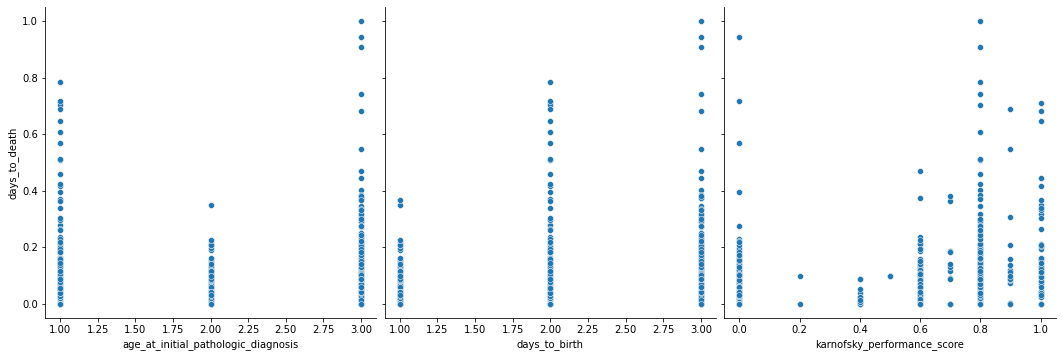

In [8]:
sns.pairplot(data, x_vars=x_vars, y_vars='days_to_death', height=5, aspect=1)

# 2 - Splitting data into train, validation and test

In [9]:
DATA_DIR = '/opt/dkube/input/'
OUT_DIR = '../data_splits/'
TRAIN_DATA = OUT_DIR + 'train/'
VAL_DATA = OUT_DIR + 'val/'
TEST_DATA = OUT_DIR + 'test/'
seed = 13
ratio = [75,15,10]
for filetype in ['CLI', 'RNA']:
    if filetype == 'CLI':
        filename = '../output/clinical/' + 'cli_data_processed.csv'
    else:
        filename = DATA_DIR + 'rna/mRNAseq.csv'
    raw_data = read_file(filename)
    data = read_file(filename)
    n_samples = len(data)
    s_ratio, case = normalize_ratio(ratio, n_samples)
    chunks, seeds = split_csv(data,s_ratio, case, seed)
    save_csv_chunks(chunks, filename, [TRAIN_DATA, VAL_DATA, TEST_DATA], filetype)   
# Splitting Images
imgfolder = DATA_DIR + '/images/imgs/'
img_names = os.listdir(imgfolder)
n_samples = len(img_names)
s_ratio, case = normalize_ratio(ratio, n_samples)
chunks = split_imgs(seed, img_names, case)
save_imgs(chunks, imgfolder, [TRAIN_DATA, VAL_DATA, TEST_DATA], 'IMG')

# 3 - Training 

## 3.1 - Reading Data 

In [10]:
DATA_DIR = '../data_splits/'
TRAIN_DATA_CLI = DATA_DIR + 'train/CLI/'
TRAIN_DATA_IMG = DATA_DIR + 'train/IMG/'
TRAIN_DATA_RNA = DATA_DIR + 'train/RNA/'

VAL_DATA_CLI = DATA_DIR + 'val/CLI/'
VAL_DATA_IMG = DATA_DIR + 'val/IMG/'
VAL_DATA_RNA = DATA_DIR + 'val/RNA/'

TEST_DATA_CLI = DATA_DIR + 'test/CLI/'
TEST_DATA_IMG = DATA_DIR + 'test/IMG/'
TEST_DATA_RNA = DATA_DIR + 'test/RNA/'

train_df = pd.read_csv(TRAIN_DATA_CLI + "cli_data_processed_train.csv")
val_df = pd.read_csv(VAL_DATA_CLI + "cli_data_processed_val.csv")
test_df = pd.read_csv(TEST_DATA_CLI + "cli_data_processed_test.csv")

Y_train = train_df['days_to_death']
Y_train = np.asarray(Y_train)
Y_train = Y_train.reshape(Y_train.shape[0],1)
train_imgs = list(train_df['bcr_patient_barcode'])

X1_train = train_df.drop(['days_to_death','bcr_patient_barcode'], axis = 1)
X1_train = np.asarray(X1_train)
X1_train = X1_train.reshape(X1_train.shape[0],X1_train.shape[1],1)


Y_val = val_df['days_to_death']
Y_val = np.asarray(Y_val)
Y_val = Y_val.reshape(Y_val.shape[0],1)

X1_val = val_df.drop(['days_to_death','bcr_patient_barcode'], axis = 1)
X1_val = np.asarray(X1_val)
X1_val = X1_val.reshape(X1_val.shape[0],X1_val.shape[1],1)


Y_test = test_df['days_to_death']
Y_test = np.asarray(Y_test)
Y_test = Y_test.reshape(Y_test.shape[0],1)
X1_test = test_df.drop(['days_to_death','bcr_patient_barcode'], axis = 1)
X1_test = np.asarray(X1_test)
X1_test = X1_test.reshape(X1_test.shape[0],X1_test.shape[1],1)


X2_train = []
X2_val = []
X2_test = []
dim = (28,28)
train_imgs = tf.io.gfile.listdir(TRAIN_DATA_IMG)
for each_img in train_imgs:
    ds = pydicom.dcmread(TRAIN_DATA_IMG + each_img)
    ds = cv2.resize(ds.pixel_array, dim, interpolation = cv2.INTER_AREA)
    X2_train.append(ds)
X2_train = np.asarray(X2_train)
print(X2_train.shape)
X2_train = X2_train.reshape(X2_train.shape[0],X2_train.shape[1],X2_train.shape[2],1)

val_imgs = tf.io.gfile.listdir(VAL_DATA_IMG)
for each_img in val_imgs:
    ds = pydicom.dcmread(VAL_DATA_IMG + each_img)
    ds = cv2.resize(ds.pixel_array, dim, interpolation = cv2.INTER_AREA)
    X2_val.append(ds)
X2_val = np.asarray(X2_val)
X2_val = X2_val.reshape(X2_val.shape[0],X2_val.shape[1],X2_val.shape[2],1)

test_imgs = tf.io.gfile.listdir(TEST_DATA_IMG)
for each_img in test_imgs:
    ds = pydicom.dcmread(TEST_DATA_IMG + each_img)
    ds = cv2.resize(ds.pixel_array, dim, interpolation = cv2.INTER_AREA)
    X2_test.append(ds)
X2_test = np.asarray(X2_test)
X2_test = X2_test.reshape(X2_test.shape[0],X2_test.shape[1],X2_test.shape[2],1)

(447, 28, 28)


## 3.2 - Building and training model on different learning rates 

In [11]:
lrs =  [0.1, 0.01, 0.02, 0.05]
epochs = 1
penalty = 0.01
img_input_shape = (28,28,1)
csv_input_shape = (15,1)
metrics = {'train_mae':[],
          'val_mae':[],
          'test_mae':[]}
for lr in lrs:
    cnn_block, cnn_input = build_cnn_block(img_input_shape, penalty)
    dense_block, csv_input = build_dense_block(csv_input_shape, penalty)
    merged = k.layers.Concatenate()([cnn_block,dense_block])
    merged = k.layers.Dense(16, activation='tanh')(merged)
    merged = k.layers.Dense(8, activation='tanh')(merged)
    merged = k.layers.Dense(1, activation='sigmoid')(merged)
    model = k.models.Model(inputs=[cnn_input, csv_input], outputs=[merged])

    ada_grad = k.optimizers.Adagrad(lr=lr, epsilon=1e-08, decay=0.0)
    model.compile(optimizer=ada_grad, loss='mse')
    history = model.fit(x=[X2_train,X1_train], y= Y_train, validation_data =([X2_val,X1_val],Y_val), 
                        epochs=epochs, verbose=1)
    train_preds = model.predict([X2_train,X1_train])
    val_preds = model.predict([X2_val,X1_val])
    test_preds = model.predict([X2_test,X1_test])
    metrics['train_mae'].append(mean_absolute_error(Y_train, train_preds))
    metrics['val_mae'].append(mean_absolute_error(Y_val, val_preds))
    metrics['test_mae'].append(mean_absolute_error(Y_test, test_preds))

14/14 [==============================] - 0s 23ms/step - loss: 1370.0752 - val_loss: 19.1613


## 3.3 Saving Model

In [12]:
version = 1
model.save(modeldir + str(1))


Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: ../model/1/assets


## 3.4 - Comparison of models on MAE

In [15]:
metrics = pd.DataFrame.from_dict(metrics)
metrics['Learning rate idx'] = [0,1,2,3]
x_vars = ['train_mae', 'val_mae', 'test_mae']
sns.pairplot(metrics, x_vars=x_vars, y_vars='Learning rate idx', kind = 'scatter', height=5, aspect=1)

In [16]:
metrics